In [1]:
library(ggplot2)
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyverse)
setwd('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# functions 

volcano_plot_2 <- function(fit, x, xlab = "Ln fold change", y, ylab = "-Log10 FDR",
    title = "LMCN data, metastatic vs non-metastatic", titleLabSize = 12, border = "full",
    pCutoff = 0.001, FCcutoff = 1.5, xlim = c(-3, 3), ylim = c(0, 10), pointsize= .2, top_n) {

    if (! x %in% names(fit)){
        stop(print(paste('The column', x, 'does not exist in the given dataframe.')))
    }

    if (! y %in% names(fit)){
        stop(print(paste('The column', y, 'does not exist in the given dataframe.')))
    }

    return(EnhancedVolcano::EnhancedVolcano(fit, lab = fit['transcript'], selectLab=top_n, x=x, xlab=xlab, y=y, ylab=ylab, title=title,
    titleLabSize=titleLabSize, border=border, pCutoff=pCutoff, FCcutoff=FCcutoff, xlim=xlim, ylim=ylim, pointSize=pointsize))
}

nmor_factor <- function (expression.data.frame, data.columns){
  gm_mean_z <- function(x){
    exp(sum(log(x)) / length(x))
  }
  edf <- expression.data.frame
  id.names <- names(edf)
  geo.mean.vec <- apply(edf[,data.columns], 1, function(x) gm_mean_z(x))
  ratios.df <- edf[,data.columns]/geo.mean.vec
  # Division by 0 gm_mean will create NAs here.
  normalization.factors <- apply(ratios.df, 2, function(x) median(x, na.rm=TRUE))
  return(normalization.factors)
}


## read in the table and then normalize and make count table for it
count_table_for_APAlog <- function(df){
    sf <- nmor_factor(df, c(8:9))
    df <- df %>% mutate(ALS = ALS_PAcount/sf[1], CTRL = ctrl_PAcount/sf[2])
    df <- df %>% gather(condition, normalized_count, `ALS`:`CTRL`) %>% arrange(pas, type, condition)
    return(df)
}
root_dir <- "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
# sub_cts <- list.files()
sub_cts <- c('Astrocytes_C9ALSvsCTRL', 'Astrocytes_sALSvsCTRL') ## Sep 20. 2022>> doing this for only astrocytes
for (ct in sub_cts){
    inp_df <- read.csv(paste0(ct,"/pas_counts.txt"), sep='\t')
    out_file <- paste0(ct,"/APAlog_pas_count_input.txt")
    out_df <- count_table_for_APAlog(inp_df)
    write.table(out_df, file=out_file, quote=F, sep='\t', row.names = F)   
}

In [3]:
## ok lets do this for for all the celltypes and conditions
run_APAlog <- function(ct) {
    
    root_dir <- "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
    ## read in and process the count dataframe
    inp_df <- read.csv(paste0(ct,"/APAlog_pas_count_input.txt"), sep='\t')
    inp_df <- inp_df[, c(1,2,10,11)]
    colnames(inp_df) <- c('transcript', 'pA.site','sample','count')
    inp_df[sapply(inp_df, is.character)] <- lapply(inp_df[sapply(inp_df, is.character)], as.factor)
    
    ## make the design table
    design_table <- data.frame(sample=c('ALS', 'CTRL'),
                           Condition=c('ALS_pathology','Control'))
    design_table$sample <- factor(design_table$sample, levels=c('CTRL', 'ALS'))
    design_table$Condition <- factor(design_table$Condition, levels=c('Control', 'ALS_pathology'))
    
    ## run the APAlog in overal mode
    fit.o_test <- APAlog::pA_logit_dev(inp_df,
                                     pA.site ~ Condition,
                                     design_table,
                                     "sample",  
                                     adj_method = "fdr")
    ## run the APAlog in pairwise mode
    fit.p_test <- APAlog::pA_logit_pairwise(inp_df, pA.site~Condition, design_table, "sample")
    
    ## merge the dataframes
    fit.op_test <- merge(fit.o_test, fit.p_test, by = "transcript")
    
    outname <- paste0(root_dir,ct,"/APAlog_res.tsv")
    write.table(fit.op_test, file=outname, quote=F, sep='\t', row.names = F)
    
    plt <- volcano_plot_2(fit.op_test,
                     x='b_ConditionALS_pathology',
                     y='p_ConditionALS_pathology',
                     title=paste0('Volcano plot for ALS vs Control for ',ct),
                     pCutoff = 0.05,
                     FCcutoff = .5,
                     ylim=c(0,10), pointsize = 1)
    plot_name <- paste0(root_dir,ct,"/APAlog_volcano_plot.pdf")
    pdf(file = plot_name)
    print(plt)
    dev.off()
    
}

re_plot_volcanos <- function(ct){
    
    root_dir <- "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
    ## read in and process the count dataframe
    inp_df <- read.csv(paste0(ct,"/APAlog_res.tsv"), sep='\t')
    top_n_switches <- inp_df %>% arrange(desc(abs(b_ConditionALS_pathology))) %>% slice(1:50)
    top_n_switches_genes <- top_n_switches['transcript']
    plt <- volcano_plot_2(inp_df,
                     x='b_ConditionALS_pathology',
                     y='p_ConditionALS_pathology',
                     title=paste0('Volcano plot for ALS vs Control for ',ct),
                     pCutoff = 0.05,
                     FCcutoff = .5,
                     ylim=c(0,10), pointsize = 1, top_n=top_n_switches_genes)
    plot_name <- paste0(root_dir,ct,"/APAlog_volcano_plot_3.pdf")
    pdf(file = plot_name)
    print(plt) 
    dev.off()
}

### adding needed extra informatio to the dataframes
add_meta_information <- function(ct){
    
    root_dir <- "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
    inp_df <- read.csv(paste0(ct,"/APAlog_res.tsv"), sep='\t')
    inp_df <- inp_df %>% mutate(strand=gsub(".*:.*:(.*)","\\1",ref_site)) %>%
                mutate(multiplyer= ifelse(strand=="+",1,-1)) %>%
                mutate(LFC_PA_Usage=b_ConditionALS_pathology*multiplyer) %>% 
                mutate(negative_logFDR=-log(p_ConditionALS_pathology, base=10)) %>%
                mutate(switch_width=as.numeric(gsub(".*:(.*):.*","\\1",alt_site)) - as.numeric(gsub(".*:(.*):.*","\\1",ref_site))) %>%
                mutate(bed = paste0(gsub("(.*):.*:.*","\\1",ref_site), ',',
                                    gsub(".*:(.*):.*","\\1",ref_site), ',',
                                    gsub(".*:(.*):.*","\\1",alt_site)))
    
    ### correcting handful of cases where the proximal and distal positions are reversed in ref_site and Alt_sites

    inp_df <- inp_df %>% mutate(correction_multiplyer = ifelse(switch_width <= -1, -1, 1)) %>%
                         mutate(switch_width=switch_width*correction_multiplyer) %>%
                         mutate(LFC_PA_Usage=LFC_PA_Usage*correction_multiplyer) %>%
                         mutate(switch_name = ifelse(correction_multiplyer==-1, paste0(gsub("(.*):.*:.*","\\1",ref_site),':',
                                                     transcript,":",gsub(".*:(.*):.*","\\1",alt_site),
                                                     ':',gsub(".*:(.*):.*","\\1",ref_site),':',strand),
                                                     paste0(gsub("(.*):.*:.*","\\1",ref_site),':',
                                                     transcript,":",gsub(".*:(.*):.*","\\1",ref_site),
                                                     ':',gsub(".*:(.*):.*","\\1",alt_site),':',strand)))
    
    outname <- paste0(root_dir,ct,"/APAlog_res_metadata_added.tsv")
    print(outname)
    write.table(inp_df, file=outname, quote=F, sep='\t', row.names = F)
    
}

## make the bed files to get the sequences
## add upstream of the proximal sites
get_bed_files <- function(ct){
    inp_df <- read.csv(paste0(ct,"/APAlog_res_metadata_added.tsv"), sep='\t')
    inp_df <- inp_df %>% filter(switch_width >= 200) %>% filter(switch_width <= 15000)
    inp_df <- data.frame(inp_df['switch_name'],inp_df['strand'])
    
    inp_df <- inp_df %>% mutate(chr=gsub("(.*):.*:.*:.*:.*","\\1",switch_name)) %>%
                          mutate(start=as.character(ifelse(strand=='+',
                                                           as.numeric(gsub(".*:.*:(.*):.*:.*","\\1",switch_name)) - 1000,
                                                           gsub(".*:.*:(.*):.*:.*","\\1",switch_name)))) %>%
                          mutate(end=as.character(ifelse(strand=='-',
                                                           as.numeric(gsub(".*:.*:.*:(.*):.*","\\1",switch_name)) + 1000,
                                                           gsub(".*:.*:.*:(.*):.*","\\1",switch_name)))) 
    
    
    inp_df <- data.frame(inp_df['chr'],inp_df['start'],inp_df['end'],inp_df['switch_name'])
    outname <- paste0(root_dir,ct,"/switch_region.bed")
    write.table(inp_df,file=outname, sep='\t', quote=F, row.names = F, col.names = F)
}

adj_p <- function(x, pcols, adj_method){
    y <- x[, pcols, drop = FALSE]
    if (adj_method == "qvalue"){
        y <- apply(y, 2, function(t) qvalue::qvalue(t)$qvalues)
    } else {
        y <- apply(y, 2, function(t) stats::p.adjust(t, method = adj_method))
    }

    newnames <- paste0(adj_method, "_", colnames(y))
    z <- data.frame(x,y)
    colnames(z)[(NCOL(x)+1) : NCOL(z)] <- newnames
    return(z)
}

# this function finds the signficance threshold based on the adjusted p values
get_sig_threshold <- function(df){
    df <- df %>% arrange(fdr_p_ConditionALS_pathology)
    return(df[which(df$fdr_p_ConditionALS_pathology > 0.05),][1,]$p_ConditionALS_pathology)
}

## changed volcano plot function
volcano_plot_2 <- function(fit, x, xlab = "Ln fold change", y, ylab = "-Log10 FDR",
    title = "LMCN data, metastatic vs non-metastatic", titleLabSize = 12, border = "full",
    pCutoff = 0.001, FCcutoff = 1.5, xlim = c(-3, 3), ylim = c(0, 10), pointsize= .2, top_n) {

    if (! x %in% names(fit)){
        stop(print(paste('The column', x, 'does not exist in the given dataframe.')))
    }

    if (! y %in% names(fit)){
        stop(print(paste('The column', y, 'does not exist in the given dataframe.')))
    }

    return(EnhancedVolcano::EnhancedVolcano(fit, lab = fit['transcript'], selectLab=top_n, x=x, xlab=xlab, y=y, ylab=ylab, title=title,
    titleLabSize=titleLabSize, border=border, pCutoff=pCutoff, FCcutoff=FCcutoff, xlim=xlim, ylim=ylim, pointSize=pointsize))
}

In [4]:
library(parallel)
r <- mclapply(sub_cts, run_APAlog, mc.cores = 32)  
r2 <- mclapply(sub_cts, re_plot_volcanos, mc.cores = 2)  
r <- mclapply(sub_cts, add_meta_information, mc.cores = 28) 
r <- mclapply(sub_cts, get_bed_files, mc.cores = 28)  

In [ ]:
# lets open all the APAlog_res_metadata_added and calculate adujsted p values, and plot volcoano plots then save new dataframes

In [ ]:
data_root = "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
# list directories that ends with 'C9ALSvsCTRL'
sub_cts <- list.dirs(data_root, recursive = F, full.names = F)
c9_als_sub_cts <- sub_cts[grep("C9ALSvsCTRL", sub_cts)]
s_als_sub_cts <- sub_cts[grep("sALSvsCTRL", sub_cts)]

In [ ]:
c9_als_sub_cts

[1] "AST-FB_C9ALSvsCTRL"           "AST-PP_C9ALSvsCTRL"          
 [3] "Astrocytes_C9ALSvsCTRL"       "Excitatory_C9ALSvsCTRL"      
 [5] "IN-PV_C9ALSvsCTRL"            "IN-SST_C9ALSvsCTRL"          
 [7] "IN-VIP_C9ALSvsCTRL"           "Inhibitory_C9ALSvsCTRL"      
 [9] "L2-3_C9ALSvsCTRL"             "L4_C9ALSvsCTRL"              
[11] "L5-6_C9ALSvsCTRL"             "L5-6-CC_C9ALSvsCTRL"         
[13] "Microglia_C9ALSvsCTRL"        "Oligodendrocytes_C9ALSvsCTRL"
[15] "OPC_C9ALSvsCTRL"

In [ ]:
s_als_sub_cts

[1] "AST-FB_sALSvsCTRL"           "AST-PP_sALSvsCTRL"          
 [3] "Astrocytes_sALSvsCTRL"       "Excitatory_sALSvsCTRL"      
 [5] "IN-PV_sALSvsCTRL"            "IN-SST_sALSvsCTRL"          
 [7] "IN-VIP_sALSvsCTRL"           "Inhibitory_sALSvsCTRL"      
 [9] "L2-3_sALSvsCTRL"             "L4_sALSvsCTRL"              
[11] "L5-6-CC_sALSvsCTRL"          "Microglia_sALSvsCTRL"       
[13] "Oligodendrocytes_sALSvsCTRL" "OPC_sALSvsCTRL"

In [57]:
# ok for every ct in c9_als_sub_cts lets open the APAlog_res_metadata_added.tsv and calculate the adjusted p values
# then save the new dataframe with the adjusted p values
for (ct in c9_als_sub_cts){
    print(ct)
    inp_df <- read.csv(paste0(data_root,ct,"/APAlog_res_metadata_added.tsv"), sep='\t')
    inp_df = adj_p(inp_df,pcols = 9, adj_method = "fdr")
    sig_threshold = get_sig_threshold(inp_df)
    ## lets plot the volcano plot and save it in data_root + /APA_usage_volcano_plots/
    volcano_plot_2(inp_df,
                     x='LFC_PA_Usage',
                     y='p_ConditionALS_pathology',
                     title=paste0('Volcano plot for ALS vs Control for ','ast'),
                     pCutoff = sig_threshold,
                     FCcutoff = .5,
                     ylim=c(0,10), pointsize = 1, top_n = 0)
    outname = paste0(data_root,'/APA_usage_volcano_plots/c9ALS_',ct,'_volcano_plot.png')
    ggsave(outname, width = 10, height = 10, units = "in", dpi = 300)
    ## lets update the sig_LFC_PA_Usage column
    ### if the p_ConditionALS_pathology < sig_threshold and LFC_PA_Usage > 0.1 then no change sig_LFC_PA_Usage 
    ### else we set the value to 0
    inp_df$sig_LFC_PA_Usage_2 <- ifelse(inp_df$p_ConditionALS_pathology < 0.02 & abs(inp_df$LFC_PA_Usage) > 0.1, inp_df$LFC_PA_Usage * 1, inp_df$LFC_PA_Usage * 0)
    outname <- paste0(data_root,ct,"/APAlog_res_metadata_added_adj_pval.tsv")
    write.table(inp_df, file=outname, quote=F, sep='\t', row.names = F)
}

[1] "AST-FB_C9ALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "AST-PP_C9ALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Astrocytes_C9ALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Excitatory_C9ALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "IN-PV_C9ALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "IN-SST_C9ALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "IN-VIP_C9ALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Inhibitory_C9ALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "L2-3_C9ALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "L4_C9ALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "L5-6_C9ALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "L5-6-CC_C9ALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Microglia_C9ALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Oligodendrocytes_C9ALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "OPC_C9ALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


In [58]:
# ok for every ct in c9_als_sub_cts lets open the APAlog_res_metadata_added.tsv and calculate the adjusted p values
# then save the new dataframe with the adjusted p values
for (ct in s_als_sub_cts){
    print(ct)
    inp_df <- read.csv(paste0(data_root,ct,"/APAlog_res_metadata_added.tsv"), sep='\t')
    inp_df = adj_p(inp_df,pcols = 9, adj_method = "fdr")
    sig_threshold = get_sig_threshold(inp_df)
    ## lets plot the volcano plot and save it in data_root + /APA_usage_volcano_plots/
    volcano_plot_2(inp_df,
                     x='LFC_PA_Usage',
                     y='p_ConditionALS_pathology',
                     title=paste0('Volcano plot for ALS vs Control for ','ast'),
                     pCutoff = sig_threshold,
                     FCcutoff = .5,
                     ylim=c(0,10), pointsize = 1, top_n = 0)
    outname = paste0(data_root,'/APA_usage_volcano_plots/sALS_',ct,'_volcano_plot.png')
    ggsave(outname, width = 10, height = 10, units = "in", dpi = 300)
    ## lets update the sig_LFC_PA_Usage column
    ### if the p_ConditionALS_pathology < sig_threshold and LFC_PA_Usage > 0.1 then no change sig_LFC_PA_Usage 
    ### else we set the value to 0
    inp_df$sig_LFC_PA_Usage_2 <- ifelse(inp_df$p_ConditionALS_pathology < 0.02 & abs(inp_df$LFC_PA_Usage) > 0.1, inp_df$LFC_PA_Usage * 1, inp_df$LFC_PA_Usage * 0)
    outname <- paste0(data_root,ct,"/APAlog_res_metadata_added_adj_pval.tsv")
    write.table(inp_df, file=outname, quote=F, sep='\t', row.names = F)
}

[1] "AST-FB_sALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "AST-PP_sALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Astrocytes_sALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Excitatory_sALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "IN-PV_sALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "IN-SST_sALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "IN-VIP_sALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Inhibitory_sALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "L2-3_sALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "L4_sALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "L5-6-CC_sALSvsCTRL"


Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Microglia_sALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "Oligodendrocytes_sALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


[1] "OPC_sALSvsCTRL"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Ignoring unknown parameters: xlim, ylim”


In [9]:
inp_df = read.csv("Excitatory_C9ALSvsCTRL/APAlog_res_metadata_added.tsv", sep='\t')
head(inp_df)

,transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionALS_pathology,p_ConditionALS_pathology,strand,multiplyer,LFC_PA_Usage,negative_logFDR,switch_width,bed,correction_multiplyer,switch_name,sig_LFC_PA_Usage
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<dbl>
1,AACS,0.0061454316,0.019491914,chr12:125124284:+,chr12:125140928:+,0.2612155,4.734204e-02,0.98335531,3.376034e-07,+,1,0.98335531,6.4715932,16644,"chr12,125124284,125140928",1,chr12:AACS:125124284:125140928:+,0.9833553
2,AACS,0.0061454316,0.019491914,chr12:125124284:+,chr12:125143316:+,1.6417462,4.866807e-52,0.26318201,1.246049e-01,+,1,0.26318201,0.9044649,19032,"chr12,125124284,125143316",1,chr12:AACS:125124284:125143316:+,0.0000000
3,AACS,0.0061454316,0.019491914,chr12:125140928:+,chr12:125143316:+,1.3805307,8.547748e-46,-0.72017330,1.476861e-08,+,1,-0.72017330,7.8306605,2388,"chr12,125140928,125143316",1,chr12:AACS:125140928:125143316:+,-0.7201733
4,AAGAB,0.0002527658,0.001115455,chr15:67201028:-,chr15:67201672:-,0.9367987,7.468705e-06,-0.04372629,8.609305e-01,-,-1,0.04372629,0.0650319,644,"chr15,67201028,67201672",1,chr15:AAGAB:67201028:67201672:-,0.0000000
5,AAGAB,0.0002527658,0.001115455,chr15:67201028:-,chr15:67202710:-,1.4704390,7.400884e-14,-1.33759094,1.070773e-07,-,-1,1.33759094,6.9703026,1682,"chr15,67201028,67202710",1,chr15:AAGAB:67201028:67202710:-,1.3375909
6,AAGAB,0.0002527658,0.001115455,chr15:67201028:-,chr15:67217079:-,1.0982487,8.045112e-08,-1.22633047,3.590218e-06,-,-1,1.22633047,5.4448792,16051,"chr15,67201028,67217079",1,chr15:AAGAB:67201028:67217079:-,1.2263305


In [10]:
pa_cnt = read.csv("Excitatory_C9ALSvsCTRL/pas_counts.txt", sep='\t')
head(pa_cnt)


,gene_name,pas,type,frac.c1,frac.c2,C1_Allcounts,C2_Allcounts,ALS_PAcount,ctrl_PAcount
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,B3GALT6,chr1:1235004:+,3' most exon,0.208,0.635,72,63,14.976,40.005
2,B3GALT6,chr1:1233729:+,3' most exon,0.792,0.365,72,63,57.024,22.995
3,PUSL1,chr1:1311677:+,3' most exon,0.295,0.207,318,244,93.810,50.508
4,PUSL1,chr1:1316604:+,3' most exon,0.244,0.226,318,244,77.592,55.144
5,PUSL1,chr1:1316141:+,3' most exon,0.217,0.231,318,244,69.006,56.364
6,PUSL1,chr1:1318689:+,3' most exon,0.244,0.335,318,244,77.592,81.740


In [11]:
print(dim(inp_df))
inp_df = inp_df[!is.na(inp_df$sig_LFC_PA_Usage),]
dim(inp_df)

[1] 41179    18


[1] 41177    18

In [12]:
# ok for every row in inp_df lets check ref_site and alt_site and sign of sig_LFC_PA_Usage,
# if the sign is positive, then we check the type of alt_site, otherwise lets check the type of ref_site and save in an new df

# lets create a new df with the following columns
# gene_name, APA_direction, APA_type,
df = data.frame(gene_name = character(), APA_direction = character(), APA_type = character(), stringsAsFactors = F)
for (i in 1:nrow(inp_df)){
    if (inp_df$sig_LFC_PA_Usage[i] > 0){
        APA_direction = 'distal'
        # seach and find the type of alt_site from the pas_counts.txt
        tmp = pa_cnt[pa_cnt$pas == inp_df$alt_site[i],]
        APA_type = tmp$type[[1]]
        gene_name = inp_df$transcript[i]
        df = rbind(df, data.frame(gene_name = gene_name, APA_direction = APA_direction, APA_type = APA_type, stringsAsFactors = F))
    } else if (inp_df$sig_LFC_PA_Usage[i] < 0){
        APA_direction = 'proximal'
        # seach and find the type of ref_site from the pas_counts.txt
        tmp = pa_cnt[pa_cnt$pas == inp_df$alt_site[i],]
        APA_type = tmp$type[[1]]
        gene_name = inp_df$transcript[i]
        df = rbind(df, data.frame(gene_name = gene_name, APA_direction = APA_direction, APA_type = APA_type, stringsAsFactors = F))
    }
    }

In [24]:
head(df)

,gene_name,APA_direction,APA_type
,<chr>,<chr>,<chr>
1,AACS,distal,Intron
2,AACS,proximal,3' most exon
3,AAGAB,distal,3' most exon
4,AAGAB,distal,Intron
5,AAGAB,distal,3' most exon
6,AAGAB,distal,Intron


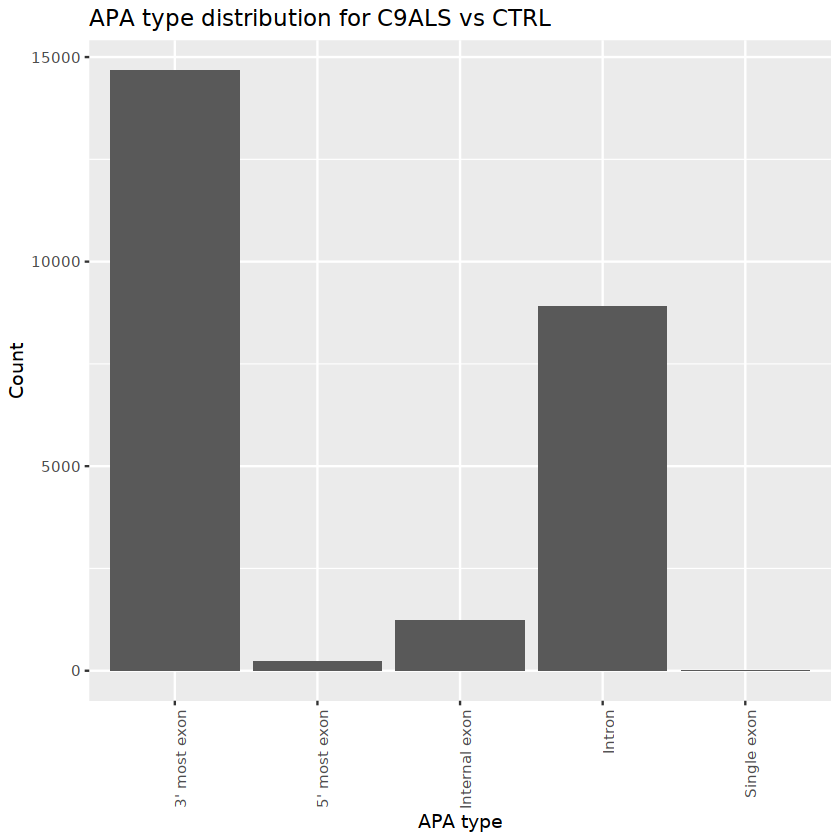

In [28]:
# okk lets plot some interesting stuff for the APA_type column and APA_direction column
# lets plot the APA_type column
ggplot(df, aes(x = APA_type)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + labs(x = 'APA type', y = 'Count', title = 'APA type distribution for C9ALS vs CTRL')

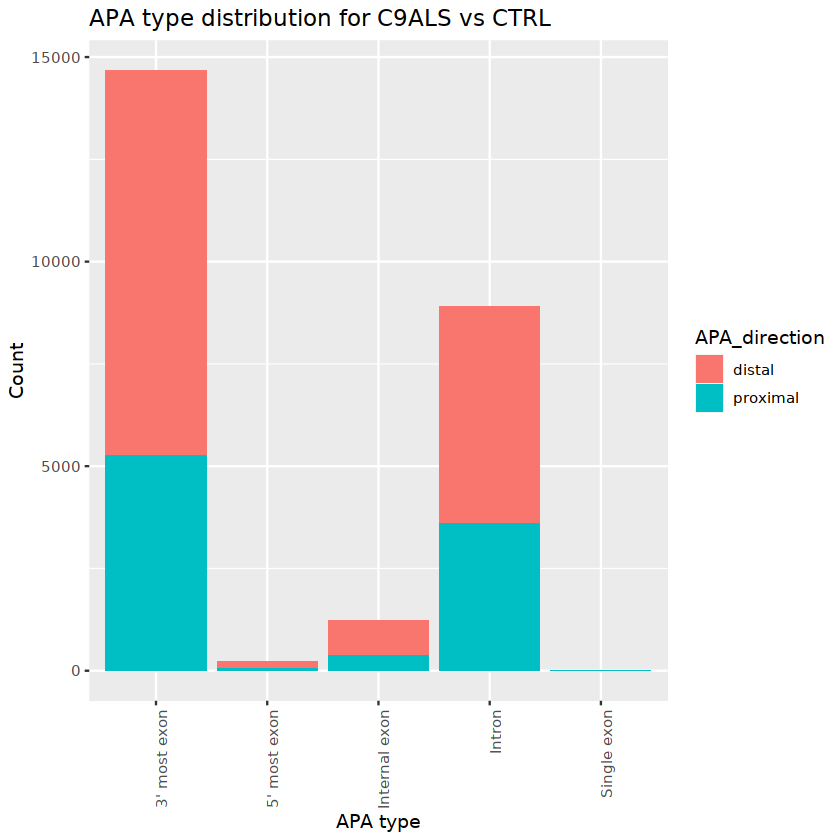

In [33]:
# lets add the APA_direction info as stacked bar plot on the APA_type 
# add the the count of each group to the top of the bar
ggplot(df, aes(x = APA_type, fill = APA_direction)) + geom_bar() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
labs(x = 'APA type', y = 'Count', title = 'APA type distribution for Excitatory Neurons C9ALS vs CTRL')

In [ ]:
# ok lets make the df for all the celltypes and plot the stacked bar plot
data_root = "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
# list directories that ends with 'C9ALSvsCTRL'
sub_cts <- list.dirs(data_root, recursive = F, full.names = F)
c9_als_sub_cts <- sub_cts[grep("C9ALSvsCTRL", sub_cts)]
s_als_sub_cts <- sub_cts[grep("sALSvsCTRL", sub_cts)]

# lets create a new df with the following columns
# gene_name, APA_direction, APA_type, celltype
df = data.frame(gene_name = character(),
 APA_direction = character(), APA_type = character(), 
 celltype = character(), APA_LFC = numeric(), p_val = numeric(), id = character(),
  stringsAsFactors = F)

# for loop for each celltype 
for (ct in c9_als_sub_cts){
    print(ct)
    inp_df = read.csv(paste0(data_root,ct,"/APAlog_res_metadata_added_adj_pval.tsv"), sep='\t')
    pa_cnt = read.csv(paste0(data_root,ct,"/pas_counts.txt"), sep='\t')
    inp_df = inp_df[!is.na(inp_df$sig_LFC_PA_Usage_2),]
    for (i in 1:nrow(inp_df)){
        if (inp_df$sig_LFC_PA_Usage_2[i] > 0){
            APA_direction = 'Distal APA'
            # seach and find the type of alt_site from the pas_counts.txt
            tmp = pa_cnt[pa_cnt$pas == inp_df$alt_site[i],]
            APA_type = tmp$type[[1]]
            gene_name = inp_df$transcript[i]
            lfc = inp_df$sig_LFC_PA_Usage_2[i]
            p1 = inp_df$p_ConditionALS_pathology[i]
            id1 = inp_df$switch_name[i]
            df = rbind(df, data.frame(gene_name = gene_name, APA_direction = APA_direction, APA_type = APA_type, celltype = ct,
            APA_LFC=lfc, p_val = p1, id = id1, stringsAsFactors = F))
            
        } else if (inp_df$sig_LFC_PA_Usage_2[i] < 0){
            APA_direction = 'Proximal APA'
            # seach and find the type of ref_site from the pas_counts.txt
            tmp = pa_cnt[pa_cnt$pas == inp_df$alt_site[i],]
            APA_type = tmp$type[[1]]
            gene_name = inp_df$transcript[i]
            lfc = inp_df$sig_LFC_PA_Usage_2[i]
            p2 = inp_df$p_ConditionALS_pathology[i]
            id2 = inp_df$switch_name[i]
            df = rbind(df, data.frame(gene_name = gene_name, APA_direction = APA_direction, APA_type = APA_type, celltype = ct,
            APA_LFC=lfc, p_val=p2, id = id2, stringsAsFactors = F))
        }
    }
}

[1] "AST-FB_C9ALSvsCTRL"
[1] "AST-PP_C9ALSvsCTRL"
[1] "Astrocytes_C9ALSvsCTRL"
[1] "Excitatory_C9ALSvsCTRL"
[1] "IN-PV_C9ALSvsCTRL"
[1] "IN-SST_C9ALSvsCTRL"
[1] "IN-VIP_C9ALSvsCTRL"
[1] "Inhibitory_C9ALSvsCTRL"
[1] "L2-3_C9ALSvsCTRL"
[1] "L4_C9ALSvsCTRL"
[1] "L5-6_C9ALSvsCTRL"
[1] "L5-6-CC_C9ALSvsCTRL"
[1] "Microglia_C9ALSvsCTRL"
[1] "Oligodendrocytes_C9ALSvsCTRL"
[1] "OPC_C9ALSvsCTRL"


In [4]:
head(df)

,gene_name,APA_direction,APA_type,celltype,APA_LFC,p_val,id
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,AARS,Distal APA,3' most exon,AST-FB_C9ALSvsCTRL,1.8258106,9.576199e-09,chr16:AARS:70252298:70252417:-
2,ABCA3,Proximal APA,Intron,AST-FB_C9ALSvsCTRL,-2.1723738,1.595700e-07,chr16:ABCA3:2275881:2336778:-
3,ABCD4,Proximal APA,Intron,AST-FB_C9ALSvsCTRL,-0.5614235,4.911879e-03,chr14:ABCD4:74285971:74294058:-
4,ABI1,Distal APA,3' most exon,AST-FB_C9ALSvsCTRL,1.7352233,3.214315e-14,chr10:ABI1:26746892:26747876:-
5,ABI1,Distal APA,Intron,AST-FB_C9ALSvsCTRL,1.3750046,3.099391e-07,chr10:ABI1:26746892:26773216:-
6,ABI2,Distal APA,3' most exon,AST-FB_C9ALSvsCTRL,1.0198610,8.657466e-03,chr2:ABI2:203431734:203432091:+


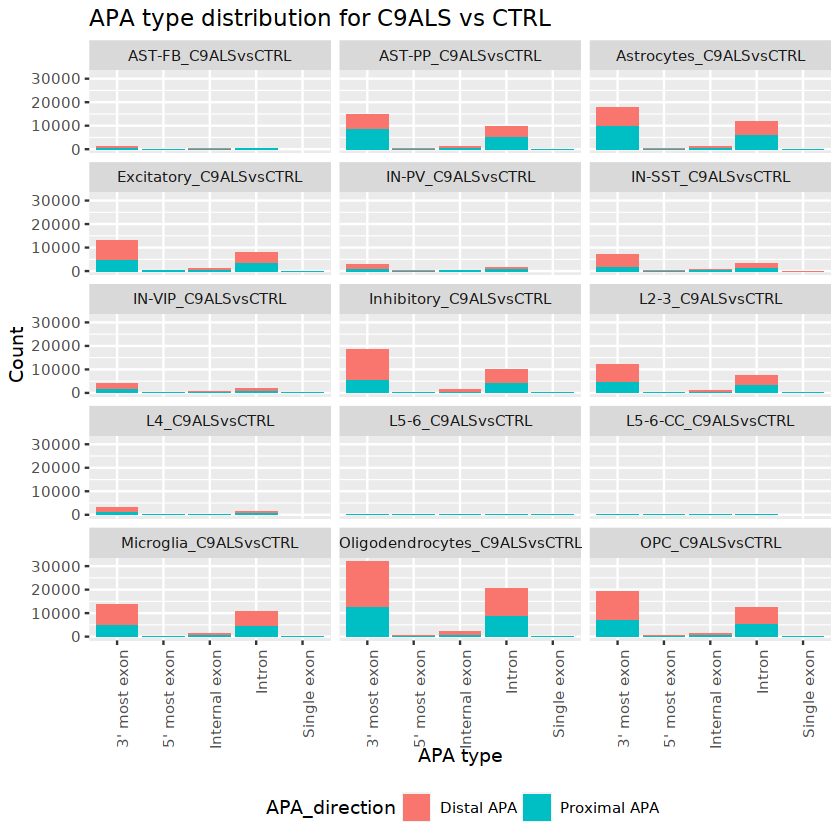

In [3]:
#  lets group the df by celltype and plot the stacked bar plot on the APA_type 
# lets make n by n facet plot for the celltypes
ggplot(df, aes(x = APA_type, fill = APA_direction)) + geom_bar() +
facet_wrap(~celltype, ncol = 3) +
theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
labs(x = 'APA type', y = 'Count', title = 'APA type distribution for C9ALS vs CTRL') +
theme(legend.position = "bottom")


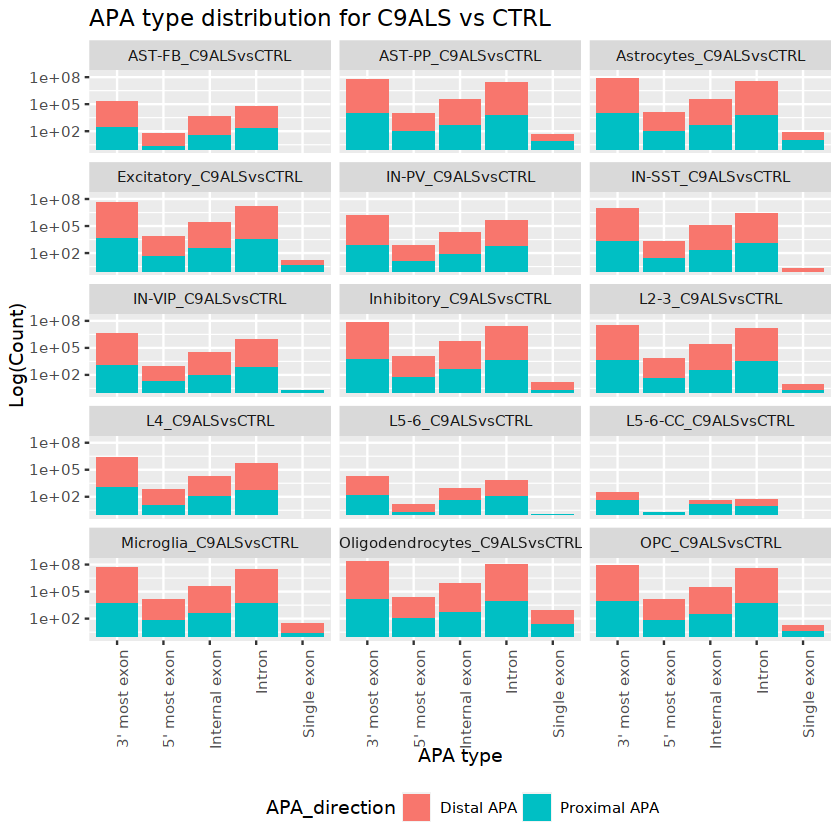

In [6]:
ggplot(df, aes(x = APA_type, fill = APA_direction)) + 
  geom_bar() +
  scale_y_log10() + # Apply log transformation to the y-axis
  facet_wrap(~celltype, ncol = 3) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = 'APA type', y = 'Log(Count)', title = 'APA type distribution for C9ALS vs CTRL') +
  theme(legend.position = "bottom")


In [32]:
# lets save the df 
write.csv(df, file = '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/apa_type_dist_allCTs.csv', row.names = F)

In [13]:
df = read.table('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/apa_type_dist_allCTs.csv', sep = ',', header = T)
head(df)

,gene_name,APA_direction,APA_type,celltype,APA_LFC,p_val,id
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,AARS,Distal APA,3' most exon,AST-FB_C9ALSvsCTRL,1.8258106,9.576199e-09,chr16:AARS:70252298:70252417:-
2,ABCA3,Proximal APA,Intron,AST-FB_C9ALSvsCTRL,-2.1723738,1.595700e-07,chr16:ABCA3:2275881:2336778:-
3,ABCD4,Proximal APA,Intron,AST-FB_C9ALSvsCTRL,-0.5614235,4.911879e-03,chr14:ABCD4:74285971:74294058:-
4,ABI1,Distal APA,3' most exon,AST-FB_C9ALSvsCTRL,1.7352233,3.214315e-14,chr10:ABI1:26746892:26747876:-
5,ABI1,Distal APA,Intron,AST-FB_C9ALSvsCTRL,1.3750046,3.099391e-07,chr10:ABI1:26746892:26773216:-
6,ABI2,Distal APA,3' most exon,AST-FB_C9ALSvsCTRL,1.0198610,8.657466e-03,chr2:ABI2:203431734:203432091:+


In [14]:
main_celltypes = c('Microglia_C9ALSvsCTRL', 'Inhibitory_C9ALSvsCTRL', 'Excitatory_C9ALSvsCTRL',
 'Astrocytes_C9ALSvsCTRL', 'OPC_C9ALSvsCTRL', 'Oligodendrocytes_C9ALSvsCTRL')
# if celltype contained main_celltypes then then keep in filtered df
df = df[df$celltype %in% main_celltypes,]
dim(df)

[1] 198270      7

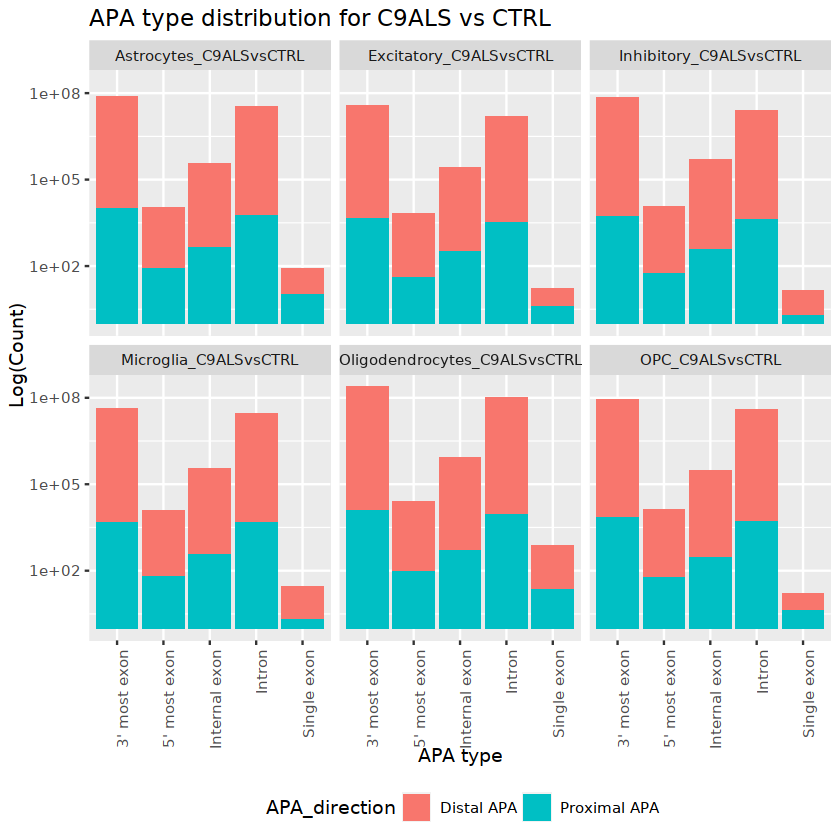

In [15]:
ggplot(df, aes(x = APA_type, fill = APA_direction)) + 
  geom_bar() +
  scale_y_log10() + # Apply log transformation to the y-axis
  facet_wrap(~celltype, ncol = 3) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = 'APA type', y = 'Log(Count)', title = 'APA type distribution for C9ALS vs CTRL') +
  theme(legend.position = "bottom")


In [5]:
# lets plot the APA_LFC for each celltype individually and save it as a standard publishable figure
for (ct in c9_als_sub_cts){
    print(ct)
    tmp = df[df$celltype == ct,]
    ggplot(tmp, aes(x = APA_type, y = APA_LFC, fill = APA_direction)) + geom_bar(stat = 'identity') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = 'APA type', y = 'APA LFC', title = paste0('APA type distribution for ', ct)) +
    theme(legend.position = "bottom")
    ggsave(paste0('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/apa_type_dist_allCTs/',ct,'.pdf'), width = 10, height = 5)
}

[1] "AST-FB_C9ALSvsCTRL"
[1] "AST-PP_C9ALSvsCTRL"
[1] "Astrocytes_C9ALSvsCTRL"
[1] "Excitatory_C9ALSvsCTRL"
[1] "IN-PV_C9ALSvsCTRL"
[1] "IN-SST_C9ALSvsCTRL"
[1] "IN-VIP_C9ALSvsCTRL"
[1] "Inhibitory_C9ALSvsCTRL"
[1] "L2-3_C9ALSvsCTRL"
[1] "L4_C9ALSvsCTRL"
[1] "L5-6_C9ALSvsCTRL"
[1] "L5-6-CC_C9ALSvsCTRL"
[1] "Microglia_C9ALSvsCTRL"
[1] "Oligodendrocytes_C9ALSvsCTRL"
[1] "OPC_C9ALSvsCTRL"


Picking joint bandwidth of 0.263

Picking joint bandwidth of 0.263



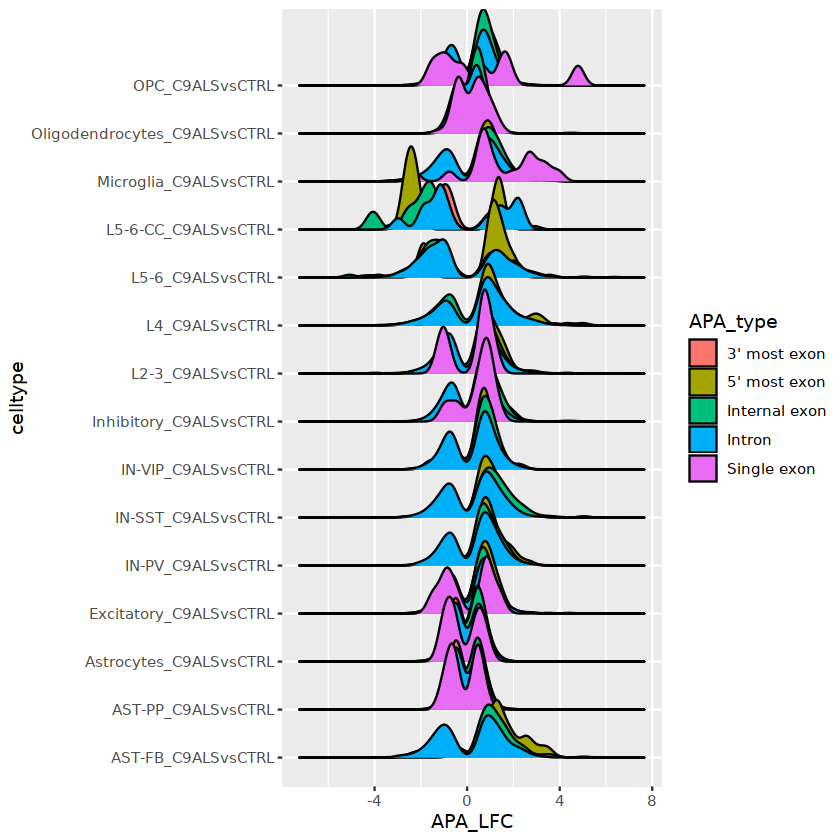

In [19]:
library(ggridges)
ggplot(df, aes(x = APA_LFC, y = celltype, fill=APA_type)) +
  geom_density_ridges()
ggsave(paste0(data_root,'/results/apa_type_dist_allCTs/apa_lfc_ridges_allCTs.pdf'), width = 10, height = 10)

Picking joint bandwidth of 0.176

Picking joint bandwidth of 0.176



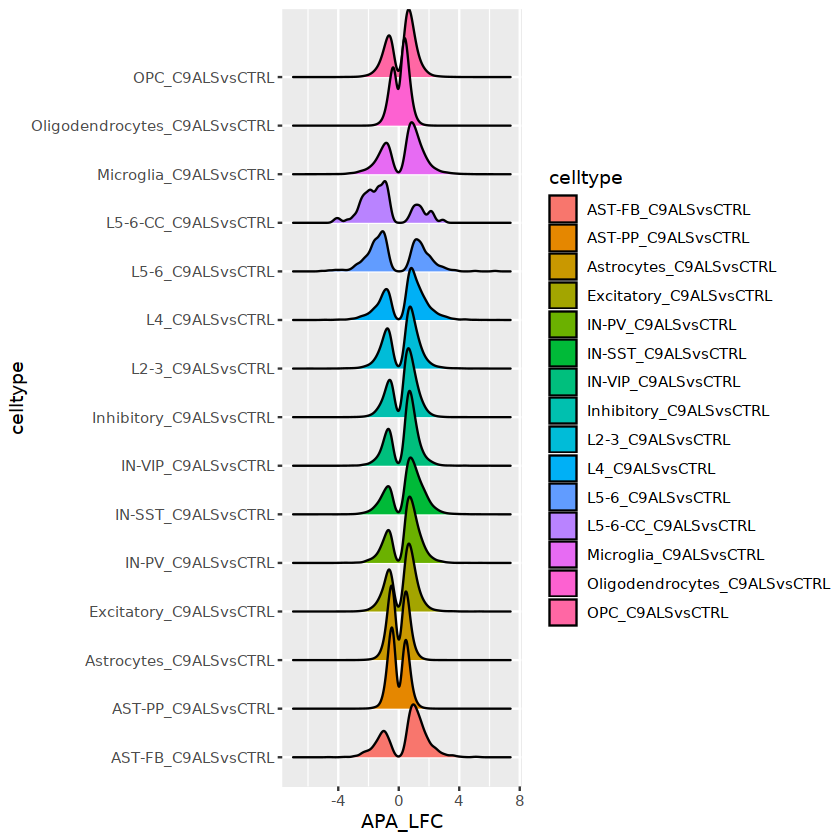

In [20]:
library(ggridges)
ggplot(df, aes(x = APA_LFC, y = celltype, fill=celltype)) +
  geom_density_ridges()
ggsave(paste0(data_root,'/results/apa_type_dist_allCTs/apa_lfc_ridges2_allCTs.pdf'), width = 10, height = 10)

Picking joint bandwidth of 0.176

Picking joint bandwidth of 0.176



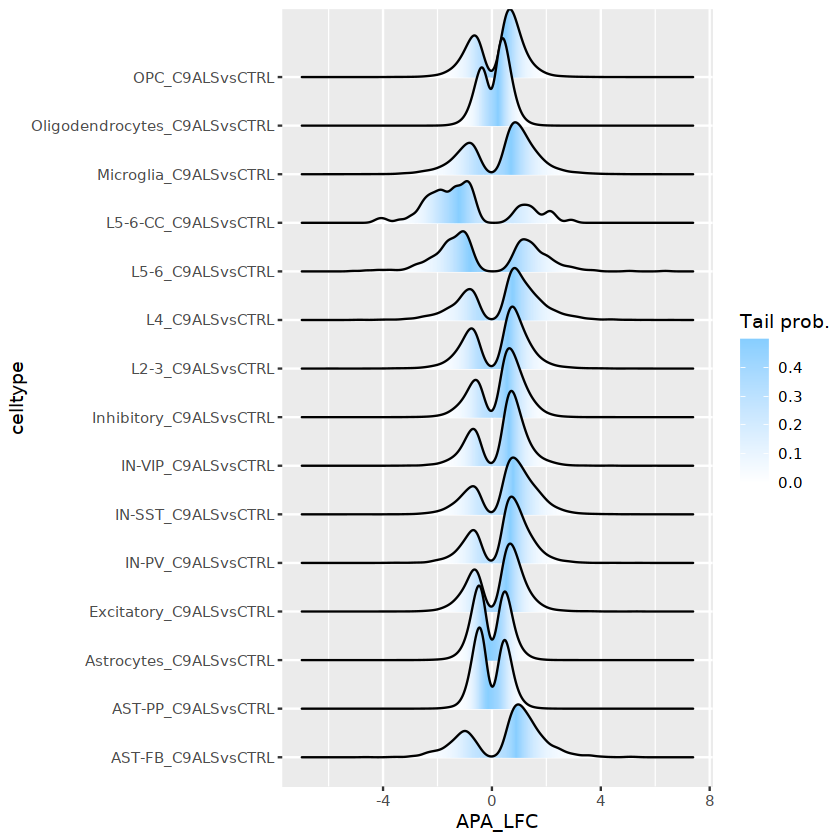

In [21]:
ggplot(df, aes(APA_LFC, y = celltype,
               fill = 0.5 - abs(0.5 - stat(ecdf)))) +
  stat_density_ridges(geom = "density_ridges_gradient", calc_ecdf = TRUE) +
  scale_fill_gradient(low = "white", high = "#87CEFF",
                      name = "Tail prob.")
ggsave(paste0(data_root,'/results/apa_type_dist_allCTs/apa_lfc_ridges3_allCTs.pdf'), width = 10, height = 10)

Picking joint bandwidth of 0.101



ERROR: Error in paste0(data_root, "/results/apa_type_dist_allCTs/apa_lfc_ridges3_mainCTs.pdf"): object 'data_root' not found


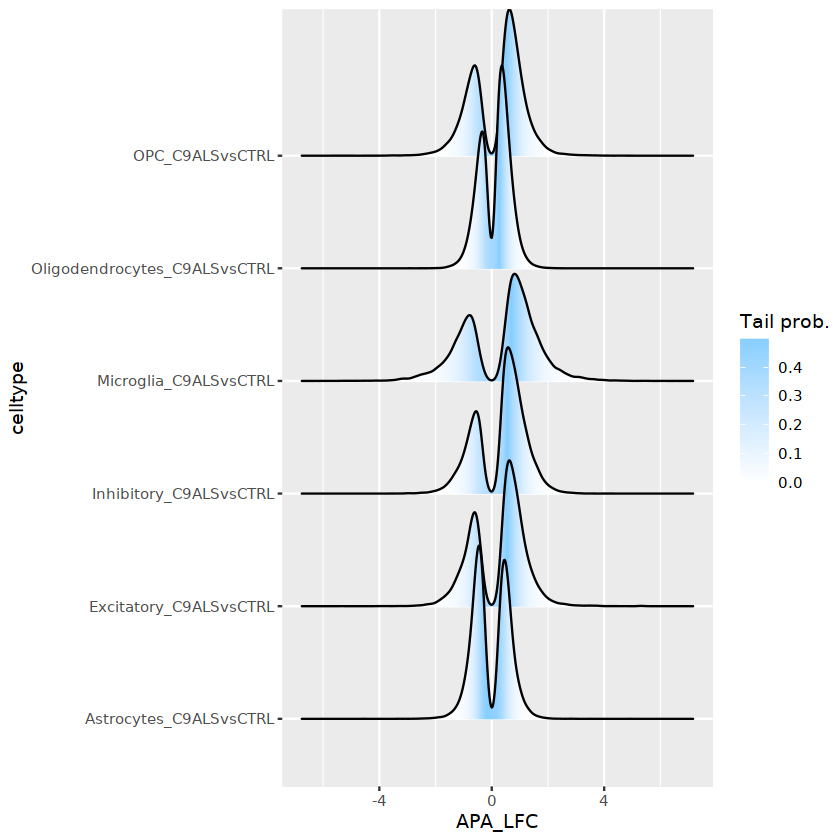

In [17]:
# for main celltypes
library(ggridges)
ggplot(df, aes(APA_LFC, y = celltype,
               fill = 0.5 - abs(0.5 - stat(ecdf)))) +
  stat_density_ridges(geom = "density_ridges_gradient", calc_ecdf = TRUE) +
  scale_fill_gradient(low = "white", high = "#87CEFF",
                      name = "Tail prob.")
ggsave(paste0(data_root,'/results/apa_type_dist_allCTs/apa_lfc_ridges3_mainCTs.pdf'), width = 10, height = 10)

In [2]:
# ok lets make the df for all the celltypes and plot the stacked bar plot
data_root = "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
# list directories that ends with 'C9ALSvsCTRL'
sub_cts <- list.dirs(data_root, recursive = F, full.names = F)
c9_als_sub_cts <- sub_cts[grep("C9ALSvsCTRL", sub_cts)]
s_als_sub_cts <- sub_cts[grep("sALSvsCTRL", sub_cts)]

# lets create a new df with the following columns
# gene_name, APA_direction, APA_type, celltype
df = data.frame(gene_name = character(),
 APA_direction = character(), APA_type = character(), 
 celltype = character(), APA_LFC = numeric(), p_val = numeric(), id = character(),
  stringsAsFactors = F)

# for loop for each celltype 
for (ct in s_als_sub_cts){
    print(ct)
    inp_df = read.csv(paste0(data_root,ct,"/APAlog_res_metadata_added_adj_pval.tsv"), sep='\t')
    pa_cnt = read.csv(paste0(data_root,ct,"/pas_counts.txt"), sep='\t')
    inp_df = inp_df[!is.na(inp_df$sig_LFC_PA_Usage_2),]
    for (i in 1:nrow(inp_df)){
        if (inp_df$sig_LFC_PA_Usage_2[i] > 0){
            APA_direction = 'Distal APA'
            # seach and find the type of alt_site from the pas_counts.txt
            tmp = pa_cnt[pa_cnt$pas == inp_df$alt_site[i],]
            APA_type = tmp$type[[1]]
            gene_name = inp_df$transcript[i]
            lfc = inp_df$sig_LFC_PA_Usage_2[i]
            p1 = inp_df$p_ConditionALS_pathology[i]
            id1 = inp_df$switch_name[i]
            df = rbind(df, data.frame(gene_name = gene_name, APA_direction = APA_direction, APA_type = APA_type, celltype = ct,
            APA_LFC=lfc, p_val = p1, id = id1, stringsAsFactors = F))
            
        } else if (inp_df$sig_LFC_PA_Usage_2[i] < 0){
            APA_direction = 'Proximal APA'
            # seach and find the type of ref_site from the pas_counts.txt
            tmp = pa_cnt[pa_cnt$pas == inp_df$alt_site[i],]
            APA_type = tmp$type[[1]]
            gene_name = inp_df$transcript[i]
            lfc = inp_df$sig_LFC_PA_Usage_2[i]
            p2 = inp_df$p_ConditionALS_pathology[i]
            id2 = inp_df$switch_name[i]
            df = rbind(df, data.frame(gene_name = gene_name, APA_direction = APA_direction, APA_type = APA_type, celltype = ct,
            APA_LFC=lfc, p_val=p2, id = id2, stringsAsFactors = F))
        }
    }
}
write.csv(df, file = '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/apa_sALS_type_dist_allCTs.csv', row.names = F)

In [ ]:
df2 = read.table('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/apa_sALS_type_dist_allCTs.csv')
df2

Warning message in file(file, "rt"):
“cannot open file '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/apa_sALS_type_dist_allCTs.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [3]:
head(df)

,gene_name,APA_direction,APA_type,celltype,APA_LFC,p_val,id
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,ABCD4,Proximal APA,Intron,AST-FB_sALSvsCTRL,-1.1352332,0.0002148512,chr14:ABCD4:74286052:74294058:-
2,ABLIM1,Distal APA,3' most exon,AST-FB_sALSvsCTRL,0.7605804,0.0120661938,chr10:ABLIM1:114431147:114435986:-
3,ABLIM1,Distal APA,3' most exon,AST-FB_sALSvsCTRL,1.0845708,0.0042798716,chr10:ABLIM1:114435210:114435986:-
4,ABLIM1,Proximal APA,Intron,AST-FB_sALSvsCTRL,-0.8059797,0.0173963098,chr10:ABLIM1:114435986:114450071:-
5,ABR,Distal APA,Intron,AST-FB_sALSvsCTRL,2.9473811,0.0025479162,chr17:ABR:1003523:1123019:-
6,ABR,Distal APA,Intron,AST-FB_sALSvsCTRL,3.2714890,0.0009710091,chr17:ABR:1055512:1123019:-


Picking joint bandwidth of 0.222

Picking joint bandwidth of 0.222



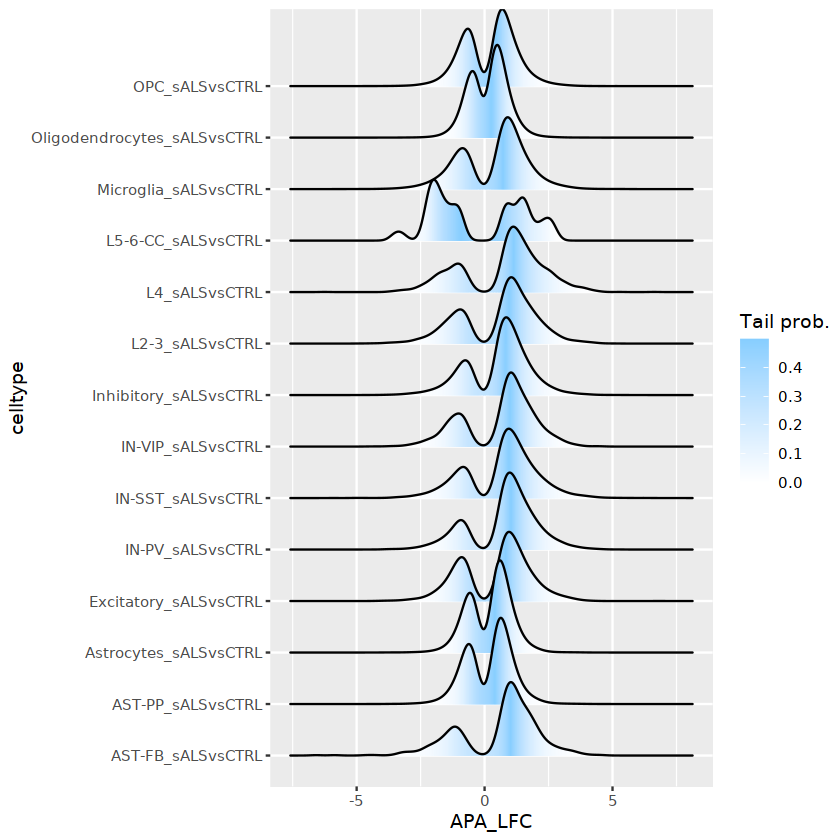

In [6]:
# for main celltypes
library(ggridges)
ggplot(df, aes(APA_LFC, y = celltype,
               fill = 0.5 - abs(0.5 - stat(ecdf)))) +
  stat_density_ridges(geom = "density_ridges_gradient", calc_ecdf = TRUE) +
  scale_fill_gradient(low = "white", high = "#87CEFF",
                      name = "Tail prob.")
ggsave(paste0(data_root,'/results/apa_type_dist_allCTs/apa_lfc_ridges3_sALS_allCTs.pdf'), width = 10, height = 10)


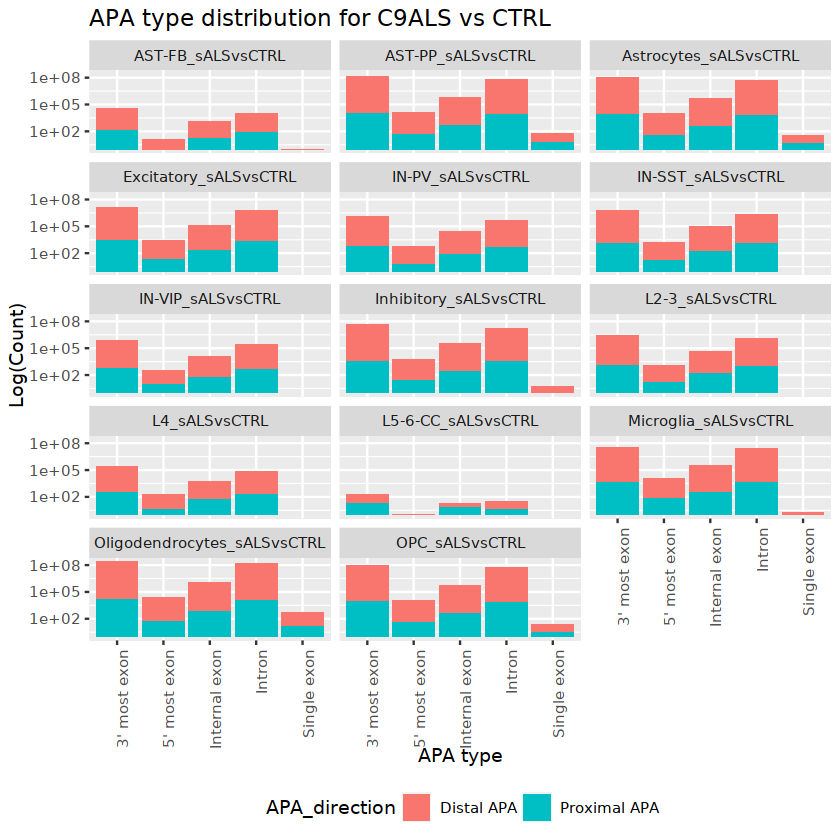

In [7]:
ggplot(df, aes(x = APA_type, fill = APA_direction)) + 
  geom_bar() +
  scale_y_log10() + # Apply log transformation to the y-axis
  facet_wrap(~celltype, ncol = 3) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = 'APA type', y = 'Log(Count)', title = 'APA type distribution for C9ALS vs CTRL') +
  theme(legend.position = "bottom")
ggsave(paste0(data_root,'/results/apa_type_dist_allCTs/sALS_allCT_APA_types.pdf'), width = 10, height = 10)


In [ ]:
main_celltypes = c('Microglia_sALSvsCTRL', 'Inhibitory_sALSvsCTRL', 'Excitatory_sALSvsCTRL',
 'Astrocytes_sALSvsCTRL', 'OPC_sALSvsCTRL', 'Oligodendrocytes_sALSvsCTRL')
# if celltype contained main_celltypes then then keep in filtered df
df = df[df$celltype %in% main_celltypes,]
dim(df)

[1] 161321      7

Picking joint bandwidth of 0.131

Picking joint bandwidth of 0.131



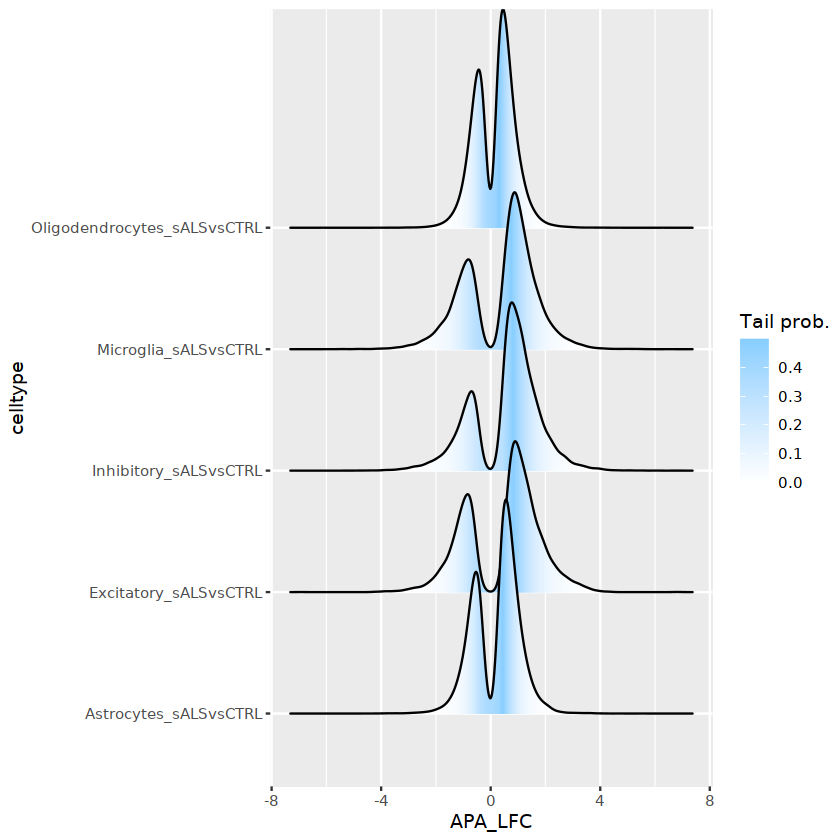

In [ ]:
ggplot(df, aes(APA_LFC, y = celltype,
               fill = 0.5 - abs(0.5 - stat(ecdf)))) +
  stat_density_ridges(geom = "density_ridges_gradient", calc_ecdf = TRUE) +
  scale_fill_gradient(low = "white", high = "#87CEFF",
                      name = "Tail prob.")
ggsave(paste0(data_root,'/results/apa_type_dist_allCTs/apa_lfc_ridges3_mainCTs.pdf'), width = 10, height = 10)

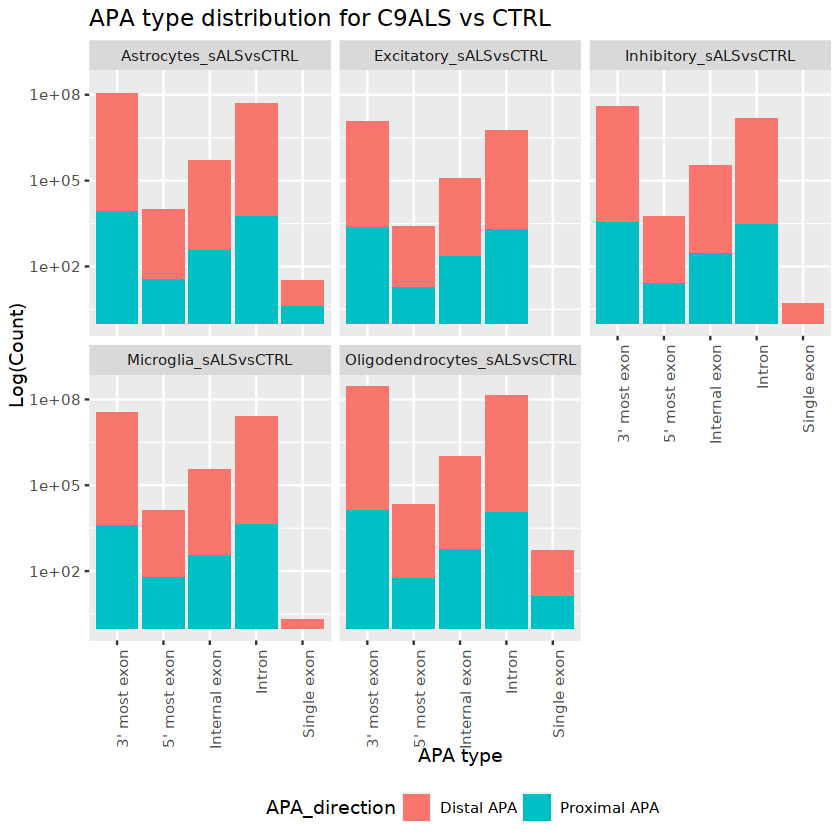

In [ ]:
ggplot(df, aes(x = APA_type, fill = APA_direction)) + 
  geom_bar() +
  scale_y_log10() + # Apply log transformation to the y-axis
  facet_wrap(~celltype, ncol = 3) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = 'APA type', y = 'Log(Count)', title = 'APA type distribution for C9ALS vs CTRL') +
  theme(legend.position = "bottom")

In [6]:
root_dir <- "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
# list the directories with 'C9ALSvsCTRL' in the name of the directory
c9_als_sub_cts <- list.dirs(root_dir, recursive = F, full.names = F)
c9_als_sub_cts <- c9_als_sub_cts[grep('vsCTRL', c9_als_sub_cts)]
c9_als_sub_cts

[1] "AST-FB_C9ALSvsCTRL"           "AST-FB_sALSvsCTRL"           
 [3] "AST-PP_C9ALSvsCTRL"           "AST-PP_sALSvsCTRL"           
 [5] "Astrocytes_C9ALSvsCTRL"       "Astrocytes_sALSvsCTRL"       
 [7] "Endothelial_ALSvsCTRL"        "Excitatory_C9ALSvsCTRL"      
 [9] "Excitatory_sALSvsCTRL"        "IN-PV_C9ALSvsCTRL"           
[11] "IN-PV_sALSvsCTRL"             "IN-SST_C9ALSvsCTRL"          
[13] "IN-SST_sALSvsCTRL"            "IN-VIP_C9ALSvsCTRL"          
[15] "IN-VIP_sALSvsCTRL"            "Inhibitory_C9ALSvsCTRL"      
[17] "Inhibitory_sALSvsCTRL"        "L2-3_C9ALSvsCTRL"            
[19] "L2-3_sALSvsCTRL"              "L4_C9ALSvsCTRL"              
[21] "L4_sALSvsCTRL"                "L5-6_C9ALSvsCTRL"            
[23] "L5-6-CC_C9ALSvsCTRL"          "L5-6-CC_sALSvsCTRL"          
[25] "Microglia_C9ALSvsCTRL"        "Microglia_sALSvsCTRL"        
[27] "Oligodendrocytes_C9ALSvsCTRL" "Oligodendrocytes_sALSvsCTRL" 
[29] "OPC_C9ALSvsCTRL"              "OPC_sALSvsCTRL"

In [35]:
get_APAS_bed_files <- function(ct){
    inp_df = read.csv(paste0(root_dir,ct,"/APAlog_res_metadata_added_adj_pval.tsv"), sep='\t', header = T)
    ref_site <- data.frame(inp_df['ref_site'],inp_df['switch_name'], inp_df['strand']) %>% mutate(chr=gsub("(.*):.*:.*","\\1",ref_site)) %>%
                            mutate(start=as.numeric(gsub(".*:(.*):.*","\\1",ref_site)) - 1000) %>%
                            mutate(end = as.numeric(gsub(".*:(.*):.*","\\1",ref_site)) + 1000)
    out_df <- data.frame(ref_site['chr'],ref_site['start'],ref_site['end'],ref_site['switch_name'])

    outname <- paste0(root_dir,ct,"/PAs_neighbour_region_ref.bed")
    write.table(out_df,file=outname, sep='\t', quote=F, row.names = F, col.names = F)

    alt_site = data.frame(inp_df['alt_site'],inp_df['switch_name'], inp_df['strand']) %>% mutate(chr=gsub("(.*):.*:.*","\\1",alt_site)) %>%
                            mutate(start=as.numeric(gsub(".*:(.*):.*","\\1",alt_site)) - 1000) %>%
                            mutate(end = as.numeric(gsub(".*:(.*):.*","\\1",alt_site)) + 1000)
    out_df <- data.frame(alt_site['chr'],alt_site['start'],alt_site['end'],alt_site['switch_name'])
    outname <- paste0(root_dir,ct,"/PAs_neighbour_region_alt.bed")
    write.table(out_df,file=outname, sep='\t', quote=F, row.names = F, col.names = F)
}



In [36]:
library(parallel)
r <- mclapply(c9_als_sub_cts, get_APAS_bed_files, mc.cores = 30)  

Warning message in mclapply(c9_als_sub_cts, get_APAS_bed_files, mc.cores = 30):
“scheduled core 7 encountered error in user code, all values of the job will be affected”


In [38]:
cat("#!/bin/bash", file = "get_fasta_for_PAs_neighbour_region_alt.sh", sep = "\n")  # Apply cat & append

for (ct in c9_als_sub_cts){
    outname <-  paste0(root_dir,ct,"/PAs_neighbour_region_alt_sequence.fa")
    root_dir <- "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
    first_part <- 'bedtools getfasta -fi ~/data/refgenome/refdata-gex-GRCh38-2020-A/fasta/genome.fa -bed '
    bed_file <- paste0(root_dir,ct,"/PAs_neighbour_region_alt.bed")
    cmd <- paste0(first_part,bed_file,' -name -fo ',outname,' &')   
    cat(cmd, file="get_fasta_for_PAs_neighbour_region_alt.sh", sep="\n", append = T)
}


cat("#!/bin/bash", file = "get_fasta_for_PAs_neighbour_region_ref.sh", sep = "\n")  # Apply cat & append

for (ct in c9_als_sub_cts){
    outname <-  paste0(root_dir,ct,"/PAs_neighbour_region_ref_sequence.fa")
    root_dir <- "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
    first_part <- 'bedtools getfasta -fi ~/data/refgenome/refdata-gex-GRCh38-2020-A/fasta/genome.fa -bed '
    bed_file <- paste0(root_dir,ct,"/PAs_neighbour_region_ref.bed")
    cmd <- paste0(first_part,bed_file,' -name -fo ',outname,' &')   
    cat(cmd, file="get_fasta_for_PAs_neighbour_region_ref.sh", sep="\n", append = T)
}

# get good example of APA for looking at IGV

In [6]:
df = read.table('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/apa_type_dist_allCTs.csv', sep = ',', header = T)
head(df)

,gene_name,APA_direction,APA_type,celltype,APA_LFC,p_val,id
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,AARS,Distal APA,3' most exon,AST-FB_C9ALSvsCTRL,1.8258106,9.576199e-09,chr16:AARS:70252298:70252417:-
2,ABCA3,Proximal APA,Intron,AST-FB_C9ALSvsCTRL,-2.1723738,1.595700e-07,chr16:ABCA3:2275881:2336778:-
3,ABCD4,Proximal APA,Intron,AST-FB_C9ALSvsCTRL,-0.5614235,4.911879e-03,chr14:ABCD4:74285971:74294058:-
4,ABI1,Distal APA,3' most exon,AST-FB_C9ALSvsCTRL,1.7352233,3.214315e-14,chr10:ABI1:26746892:26747876:-
5,ABI1,Distal APA,Intron,AST-FB_C9ALSvsCTRL,1.3750046,3.099391e-07,chr10:ABI1:26746892:26773216:-
6,ABI2,Distal APA,3' most exon,AST-FB_C9ALSvsCTRL,1.0198610,8.657466e-03,chr2:ABI2:203431734:203432091:+


In [6]:
# STMN2, UNC13A

STMN2_df <- df %>% filter(gene_name=='STMN2')
UNC13A_df <- df %>% filter(gene_name=='UNC13A')

In [7]:
table(STMN2_df$APA_type)


3' most exon 
          62 

In [8]:
table(UNC13A_df$APA_type)


3' most exon       Intron 
           3            8 

In [9]:
UNC13A_df %>% filter(APA_type=='Intron') 

gene_name,APA_direction,APA_type,celltype,APA_LFC,p_val,id
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
UNC13A,Proximal APA,Intron,Excitatory_C9ALSvsCTRL,-0.4903340,1.733895e-06,chr19:UNC13A:17601328:17631736:-
UNC13A,Proximal APA,Intron,Excitatory_C9ALSvsCTRL,-0.7735165,1.723518e-08,chr19:UNC13A:17601450:17631736:-
UNC13A,Proximal APA,Intron,Excitatory_C9ALSvsCTRL,-0.4319757,4.854147e-03,chr19:UNC13A:17603303:17631736:-
UNC13A,Distal APA,Intron,Inhibitory_C9ALSvsCTRL,0.3797554,9.273746e-04,chr19:UNC13A:17601328:17631736:-
UNC13A,Proximal APA,Intron,Inhibitory_C9ALSvsCTRL,-0.4429246,5.995790e-04,chr19:UNC13A:17601450:17631736:-
UNC13A,Proximal APA,Intron,L2-3_C9ALSvsCTRL,-0.5769352,2.220665e-06,chr19:UNC13A:17601328:17631736:-
UNC13A,Proximal APA,Intron,L2-3_C9ALSvsCTRL,-0.8747697,1.584959e-08,chr19:UNC13A:17601450:17631736:-
UNC13A,Proximal APA,Intron,L2-3_C9ALSvsCTRL,-0.4448204,1.109581e-02,chr19:UNC13A:17603303:17631736:-


In [10]:
STMN2_df

gene_name,APA_direction,APA_type,celltype,APA_LFC,p_val,id
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
STMN2,Proximal APA,3' most exon,AST-PP_C9ALSvsCTRL,-0.8104492,1.566478e-05,chr8:STMN2:79664876:79665156:+
STMN2,Proximal APA,3' most exon,AST-PP_C9ALSvsCTRL,-0.7607906,6.685107e-05,chr8:STMN2:79664876:79665267:+
STMN2,Proximal APA,3' most exon,AST-PP_C9ALSvsCTRL,-0.8182397,2.390144e-10,chr8:STMN2:79664876:79666118:+
STMN2,Distal APA,3' most exon,Astrocytes_C9ALSvsCTRL,0.6205200,4.560916e-03,chr8:STMN2:79654962:79664876:+
STMN2,Proximal APA,3' most exon,Astrocytes_C9ALSvsCTRL,-0.8890729,2.016617e-07,chr8:STMN2:79664876:79665156:+
STMN2,Proximal APA,3' most exon,Astrocytes_C9ALSvsCTRL,-0.7365801,2.413121e-05,chr8:STMN2:79664876:79665267:+
STMN2,Proximal APA,3' most exon,Astrocytes_C9ALSvsCTRL,-0.9456134,1.373245e-14,chr8:STMN2:79664876:79666162:+
STMN2,Distal APA,3' most exon,Excitatory_C9ALSvsCTRL,0.9988768,1.981833e-16,chr8:STMN2:79654962:79664876:+
STMN2,Distal APA,3' most exon,Excitatory_C9ALSvsCTRL,0.9528529,1.390399e-08,chr8:STMN2:79654962:79665156:+


In [1]:
17601328 - 17631736

[1] -30408

In [12]:
df %>% filter(APA_type=='Intron') %>% filter(abs(APA_LFC) > 5)

gene_name,APA_direction,APA_type,celltype,APA_LFC,p_val,id
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
GEM,Distal APA,Intron,AST-FB_C9ALSvsCTRL,5.307788,5.827949e-03,chr8:GEM:94249253:94257780:-
PER1,Distal APA,Intron,AST-FB_C9ALSvsCTRL,5.169361,5.278420e-03,chr17:PER1:8140472:8144056:-
HELQ,Proximal APA,Intron,Excitatory_C9ALSvsCTRL,-5.327759,1.136484e-09,chr4:HELQ:83407367:83452280:-
PCDHA1,Distal APA,Intron,Excitatory_C9ALSvsCTRL,5.314336,1.107710e-18,chr5:PCDHA1:140851110:140868240:+
PCDHA2,Distal APA,Intron,Excitatory_C9ALSvsCTRL,5.307216,1.881627e-18,chr5:PCDHA2:140851110:140868240:+
PCDHA3,Distal APA,Intron,Excitatory_C9ALSvsCTRL,5.308560,1.863828e-18,chr5:PCDHA3:140851110:140868240:+
PCDHA4,Distal APA,Intron,Excitatory_C9ALSvsCTRL,5.306317,3.661419e-18,chr5:PCDHA4:140851110:140868240:+
PCDHA5,Distal APA,Intron,Excitatory_C9ALSvsCTRL,5.311458,2.220098e-18,chr5:PCDHA5:140851110:140868240:+
PCDHA6,Distal APA,Intron,Excitatory_C9ALSvsCTRL,5.311740,1.806722e-18,chr5:PCDHA6:140851110:140868240:+
